# <font color='green'>Series de tiempo</font>
### Profesor: Act Fernando Ortega  
###  Curso : DATA SCIENCE AND MACHINE LEARNING APPLIED TO FINANCIAL MARKETS  

## Caso de estudio en temperaturas: Como la estacionalidad afecta un modelo ARIMA

En series de tiempo relacionadas con temperaturas, la estacionalidad juega un papel crucial, ya que las temperaturas suelen seguir patrones cíclicos predecibles, como cambios entre estaciones (primavera, verano, etc.). Estos ciclos introducen dependencias temporales que un modelo ARIMA estándar no puede capturar adecuadamente sin modificaciones.

El modelo ARIMA (Autoregressive Integrated Moving Average) está diseñado para datos estacionarios, lo que significa que las propiedades estadísticas de la serie, como la media y la varianza, deben ser constantes en el tiempo. Sin embargo, la estacionalidad viola esta suposición, ya que introduce variaciones sistemáticas en los datos.

### Impacto de la estacionalidad en un modelo ARIMA  
* Ajuste incorrecto:

Un modelo ARIMA básico tiende a subestimar o ignorar los ciclos repetitivos de los datos, lo que puede llevar a predicciones inexactas.
* Errores no aleatorios:

Si la estacionalidad no se maneja, los residuales mostrarán patrones claros de autocorrelación en lugar de comportarse como ruido blanco.
* Solución: SARIMA (Seasonal ARIMA):

SARIMA extiende ARIMA al incluir términos específicos para capturar estacionalidad, modelando los ciclos repetitivos con parámetros adicionales.

# Importación de las librerías necesarias

In [1]:
from pandas import read_csv
from matplotlib import pyplot as plt  
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import norm
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import requests
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import warnings
sns.set()

# Suprimir los warnings
warnings.filterwarnings("ignore")

### Carga de archivos

Se usará la  API de Open Meteo la cual es un servicio gratuito y de acceso público que proporciona datos meteorológicos históricos, actuales y predicciones del clima. Está diseñada específicamente para facilitar el acceso a información meteorológica sin necesidad de autenticación ni claves de acceso, lo que la hace ideal para proyectos académicos, análisis de datos y aplicaciones en tiempo real.



In [2]:
# Definir parámetros de la API
params = {
    "latitude": 19.43,  # latitud y longitud de la ciudad de mexico
    "longitude": -99.13,
    "start_date": "2004-11-10",
    "end_date": "2024-11-10",
    "daily": "temperature_2m_max,temperature_2m_min,temperature_2m_mean", # temperatura máxima, mínima y promedio
    "timezone": "auto"
}

# Realizar la consulta a la API
url = "https://archive-api.open-meteo.com/v1/archive"
response = requests.get(url, params=params)

# Verificar si la respuesta es exitosa
if response.status_code == 200:
    data = response.json()
    
    # Convertir a DataFrame
    df = pd.DataFrame(data["daily"])
    
    # Mostrar y guardar el DataFrame
    print(df.head())
    df.to_csv("climate_data.csv", index=False)
else:
    print(f"Error: {response.status_code} - {response.text}")

         time  temperature_2m_max  temperature_2m_min  temperature_2m_mean
0  2004-11-10                22.8                 6.1                 14.8
1  2004-11-11                22.6                 7.4                 14.4
2  2004-11-12                19.4                 5.9                 12.2
3  2004-11-13                20.6                 6.1                 13.9
4  2004-11-14                19.9                10.4                 14.8


### Análisis de DF

In [3]:
df.shape

(7306, 4)

In [4]:
df.columns

Index(['time', 'temperature_2m_max', 'temperature_2m_min',
       'temperature_2m_mean'],
      dtype='object')

In [5]:
df.describe()

,temperature_2m_max,temperature_2m_min,temperature_2m_mean
count,7306.000000,7306.000000,7306.000000
mean,22.709348,10.469176,16.149042
std,3.276001,2.747780,2.471626
min,9.700000,-0.400000,4.700000
25%,20.600000,8.500000,14.800000
50%,22.300000,11.000000,16.100000
75%,24.700000,12.600000,17.500000
max,34.100000,17.000000,25.400000


### limpieza y procesamiento

In [6]:
# Validamos NA´s
df.isna().sum()

time                   0
temperature_2m_max     0
temperature_2m_min     0
temperature_2m_mean    0
dtype: int64

In [7]:
# Dada la estacionalidad evidente (365 al ser diaria), un modelo SARIMA tardaria mucho en calibrar
# como propuesta se hacen buckets de un mes con la temperatura promedio

serie = pd.DataFrame(df.groupby(pd.to_datetime(df['time']).dt.to_period('M'))['temperature_2m_mean'].mean())

In [8]:
serie.index = serie.index.to_timestamp()  # convertimos el indice en date time

In [9]:
serie.iloc[:,0].mean()  #validamos la temperatura promedio de toda la serie

16.150306236110772

In [10]:
serie

,temperature_2m_mean
time,
2004-11-01,15.166667
2004-12-01,12.912903
2005-01-01,12.906452
2005-02-01,15.050000
2005-03-01,16.154839
...,...
2024-07-01,17.029032
2024-08-01,16.916129
2024-09-01,16.893333


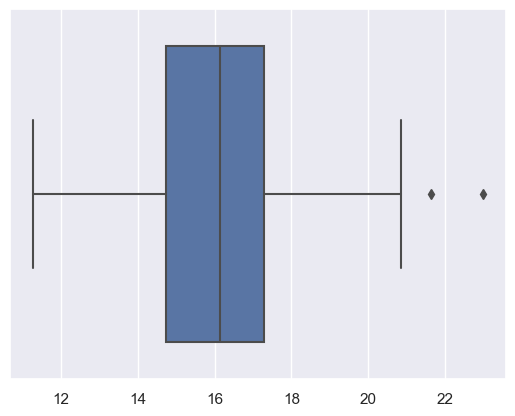

In [11]:
sns.boxplot(x=serie.values)
plt.show()

In [12]:
lower_percentile = serie.quantile(0.01)  # 1er percentil
upper_percentile = serie.quantile(0.99)  # 99% percentil

serie = serie[(serie >= lower_percentile) & (serie <= upper_percentile)]

In [13]:
# Validamos NA´s
serie.isna().sum()

temperature_2m_mean    6
dtype: int64

In [14]:
serie = serie.interpolate()

In [15]:
serie.isna().sum()

temperature_2m_mean    0
dtype: int64

In [16]:
serie

,temperature_2m_mean
time,
2004-11-01,15.166667
2004-12-01,12.912903
2005-01-01,12.906452
2005-02-01,15.050000
2005-03-01,16.154839
...,...
2024-07-01,17.029032
2024-08-01,16.916129
2024-09-01,16.893333


# Validar estacionariedad
## B-J paso 1

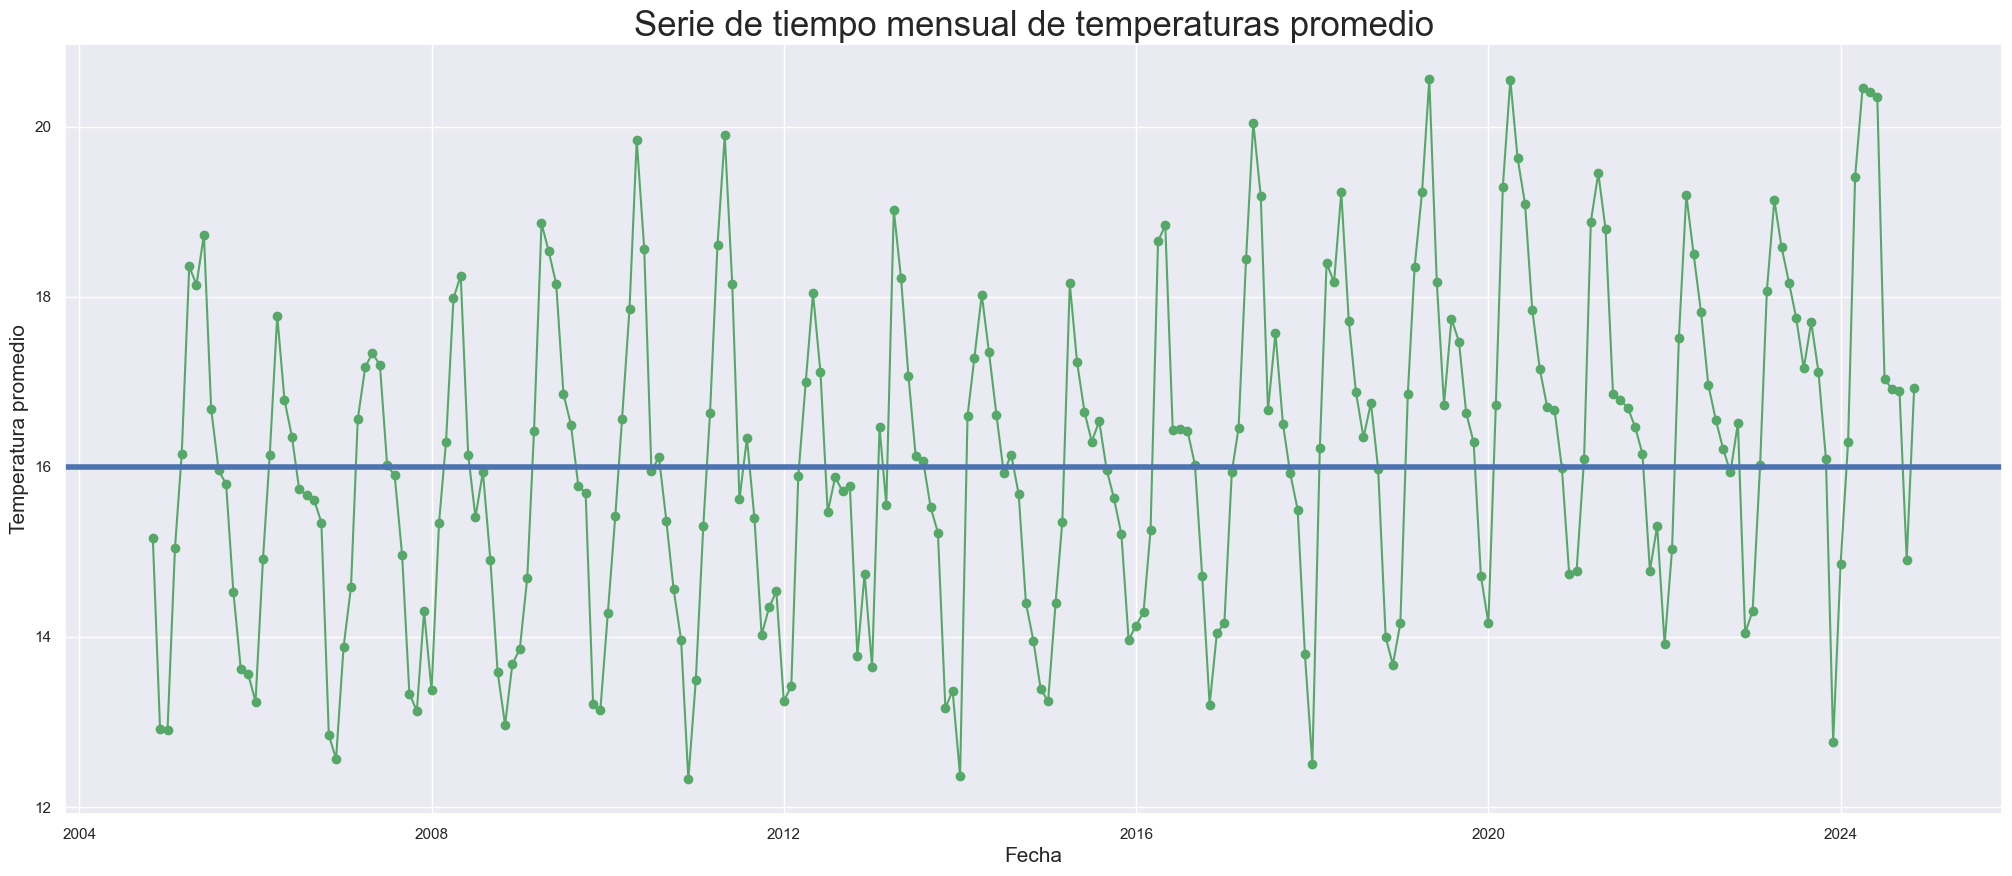

In [18]:
# Graficar la serie temporal

plt.figure(figsize=(25,10))

plt.plot(serie,"go-")
plt.axhline(16,linewidth=4)
plt.title("Serie de tiempo mensual de temperaturas promedio",fontsize=25)
plt.xlabel("Fecha",fontsize=15)
plt.ylabel("Temperatura promedio",fontsize=15)
plt.show()  

## Validar con dickey fuller estacionariedad

In [13]:
X = serie

result = adfuller(X, maxlag=1, regression="c", autolag="AIC")   # maxlag  resagoz /// regression tipo de regresion  n=none
                                                                                        #c constante  ct const y tendencia
                                                                                        # autolag metodo de calib

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -8.458505
p-value: 0.000000


In [17]:
result

(-8.458505375815857,
 1.590647324935707e-13,
 1,
 239,
 {'1%': -3.458010773719797,
  '5%': -2.8737103617125186,
  '10%': -2.5732559963936206},
 751.0190647178774)

In [ ]:
## serie estacionaria

## Funciones de autocorrelación

## ACF

Text(0.5, 1.0, 'Autocorrelación (ACF)')

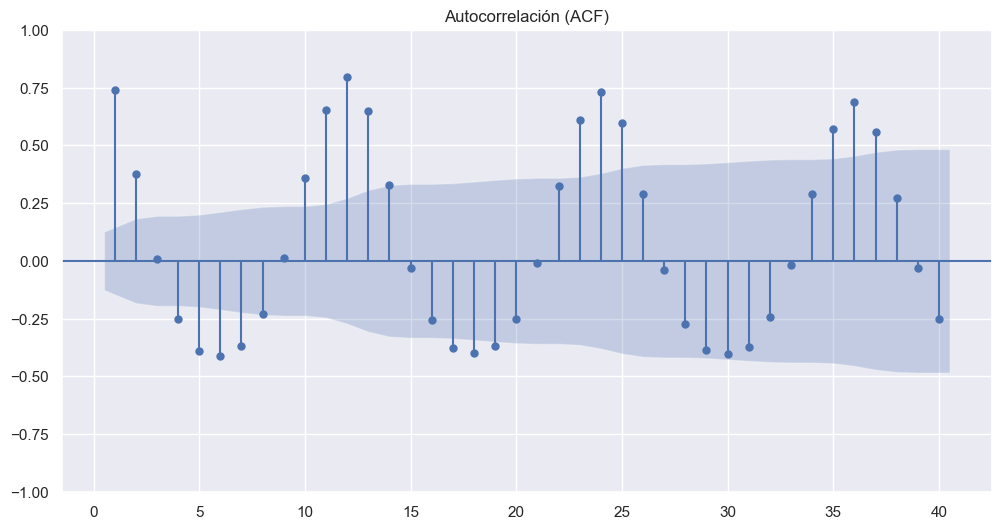

In [19]:
# Graficar la autocorrelación (ACF) y autocorrelación parcial (PACF)
plt.figure(figsize=(12, 6))

# Autocorrelación (ACF)
plot_acf(serie, lags=40, ax=plt.gca(),zero=False)
plt.title('Autocorrelación (ACF)')

## PACF

Text(0.5, 1.0, 'Autocorrelación Parcial (PACF)')

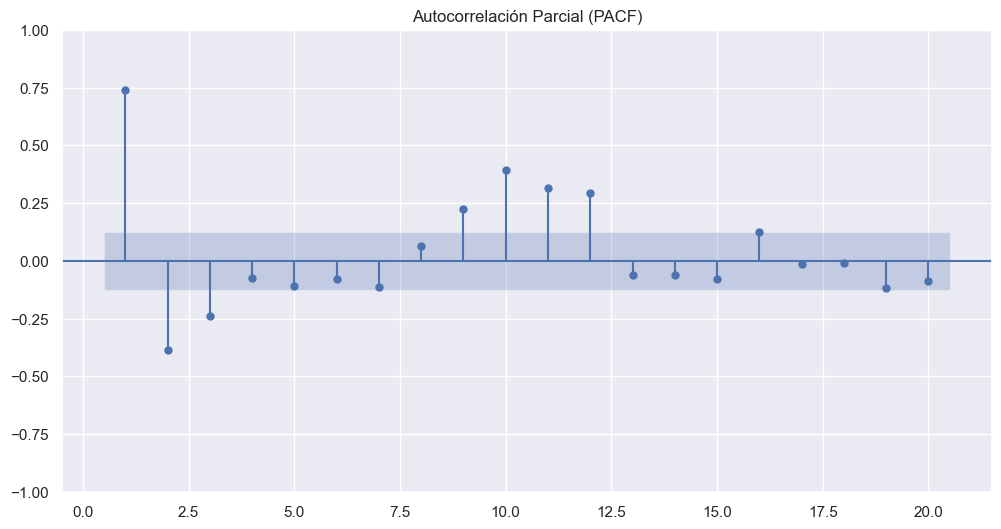

In [19]:
# Autocorrelación parcial (PACF)
plt.figure(figsize=(12, 6))

plot_pacf(serie, lags=20, ax=plt.gca(), method='ywm',zero=False)
plt.title('Autocorrelación Parcial (PACF)')

## Seleccion autoarima  : Modelo sin estacionalidad ARIMA

## B-J paso 2

In [20]:
from pmdarima.arima import auto_arima
from pmdarima.arima import AutoARIMA
from pmdarima.arima import ADFTest

In [21]:
adf_test = ADFTest(alpha = 0.05)

adf_test.should_diff(serie)

(0.01, False)

In [22]:
## dividimos en train test
#Spliting the dataset into train and test

train = serie[:229]
test = serie[229:]

train.tail()
test.head()

,temperature_2m_mean
time,
2023-12-01,12.764516
2024-01-01,14.861290
2024-02-01,16.296552
2024-03-01,19.409677
2024-04-01,20.453333


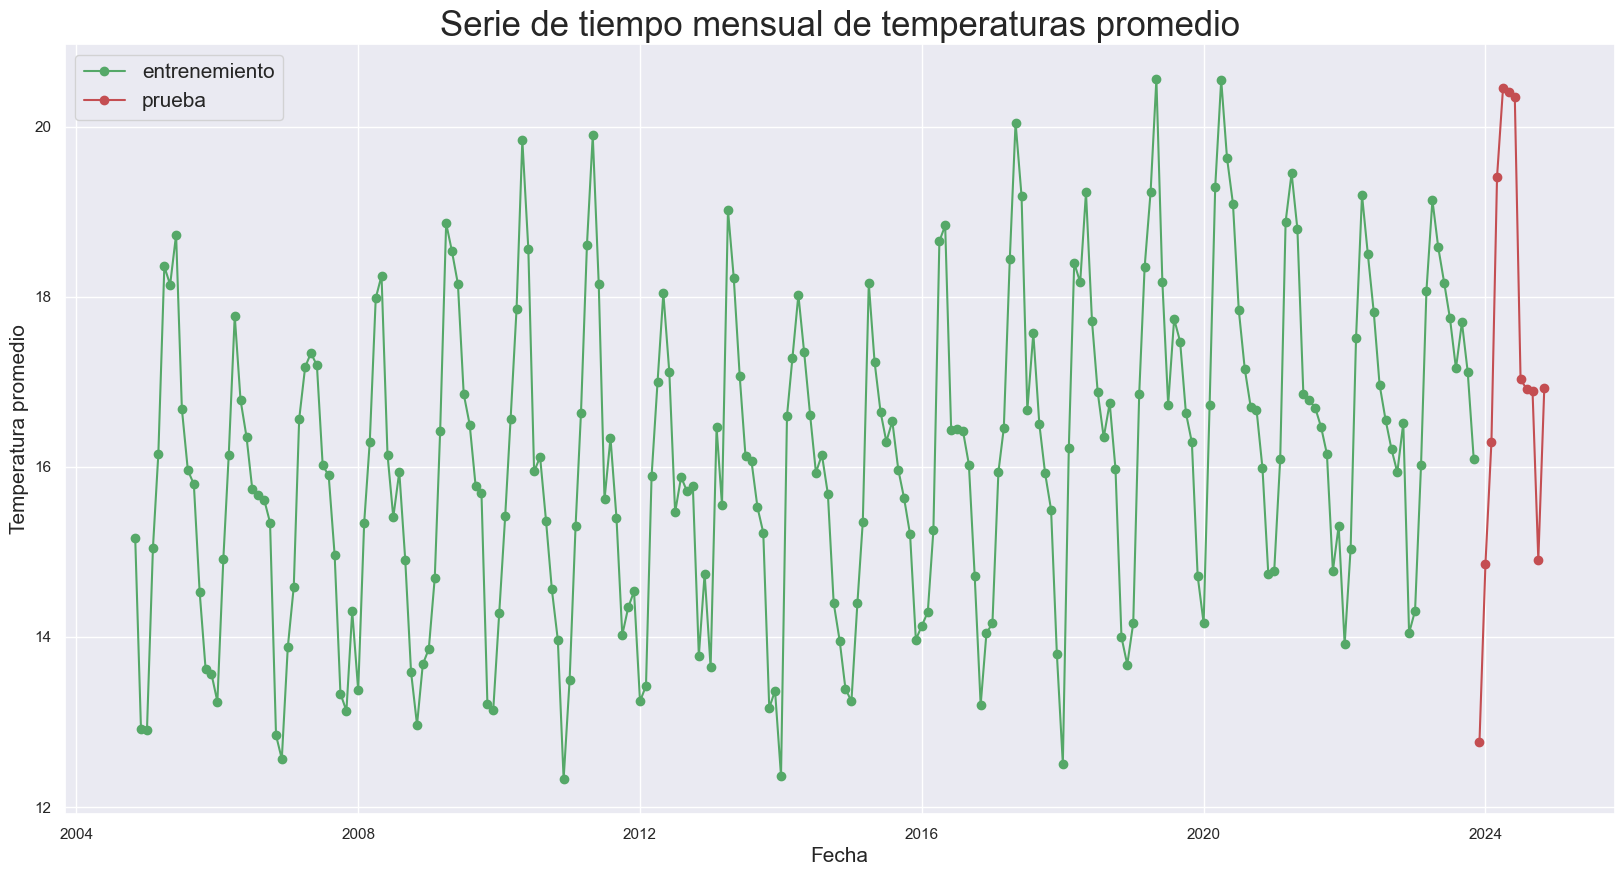

In [23]:
plt.figure(figsize=(20,10))
plt.plot(train.iloc[:,0],"go-",label="entrenemiento")

plt.plot(test.iloc[:,0],"ro-",label="prueba")
plt.title("Serie de tiempo mensual de temperaturas promedio",fontsize=25)
plt.xlabel("Fecha",fontsize=15)
plt.ylabel("Temperatura promedio",fontsize=15)
plt.legend(loc="best",fontsize=15)
plt.show()  



In [24]:
arima_model_ne =  auto_arima(train,start_p=0, d=0, start_q=0, 
                          max_p=4, max_d=4, max_q=4, seasonal=False, 
                          error_action='ignore',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )
AutoARIMA()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1927.239, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1643.386, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=770.708, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=772.214, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=771.229, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1402.550, Time=0.18 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=734.992, Time=0.31 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=667.809, Time=0.35 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=767.931, Time=0.31 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=inf, Time=nan sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=0.61 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=768.258, Time=0.39 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=703.281, Time=0.45 

AutoARIMA()

In [25]:
arima_model_ne.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  229
Model:               SARIMAX(3, 0, 2)   Log Likelihood                -327.904
Date:                Wed, 20 Nov 2024   AIC                            667.809
Time:                        15:36:39   BIC                            688.411
Sample:                    11-01-2004   HQIC                           676.120
                         - 11-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.6147      0.035     74.850      0.000       2.546       2.683
ar.L2         -2.4907      0.065    -38.343      0.000      -2.618      -2.363
ar.L3          0.8759      0.033     26.460      0.000       0.811       0.941
ma.L1         -1.8119      0.044    -40.824      0.000      -1.899      -1.725
ma.L2          0.8652      0.045     19.429      0.000       0.778       0.952
sigma2         0.9847      0.088     11.136      0.000       0.811       1.158
===================================================================================
Ljung-Box (L1) (Q):                   0.62   Jarque-Bera (JB):                 0.96
Prob(Q):                              0.43   Prob(JB):                         0.62
Heteroskedasticity (H):               1.34   Skew:                             0.12
Prob(H) (two-sided):                  0.20   Kurtosis:                         3.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
prediction_ne = pd.DataFrame(arima_model_ne.predict(n_periods = 12))
prediction_ne.columns = ['predicted_yt']
prediction_ne

,predicted_yt
2023-12-01,15.821479
2024-01-01,15.969325
2024-02-01,16.448800
2024-03-01,17.093219
2024-04-01,17.713481
2024-05-01,18.150246
2024-06-01,18.311861
2024-07-01,18.189903
2024-08-01,17.851063
2024-09-01,17.410408


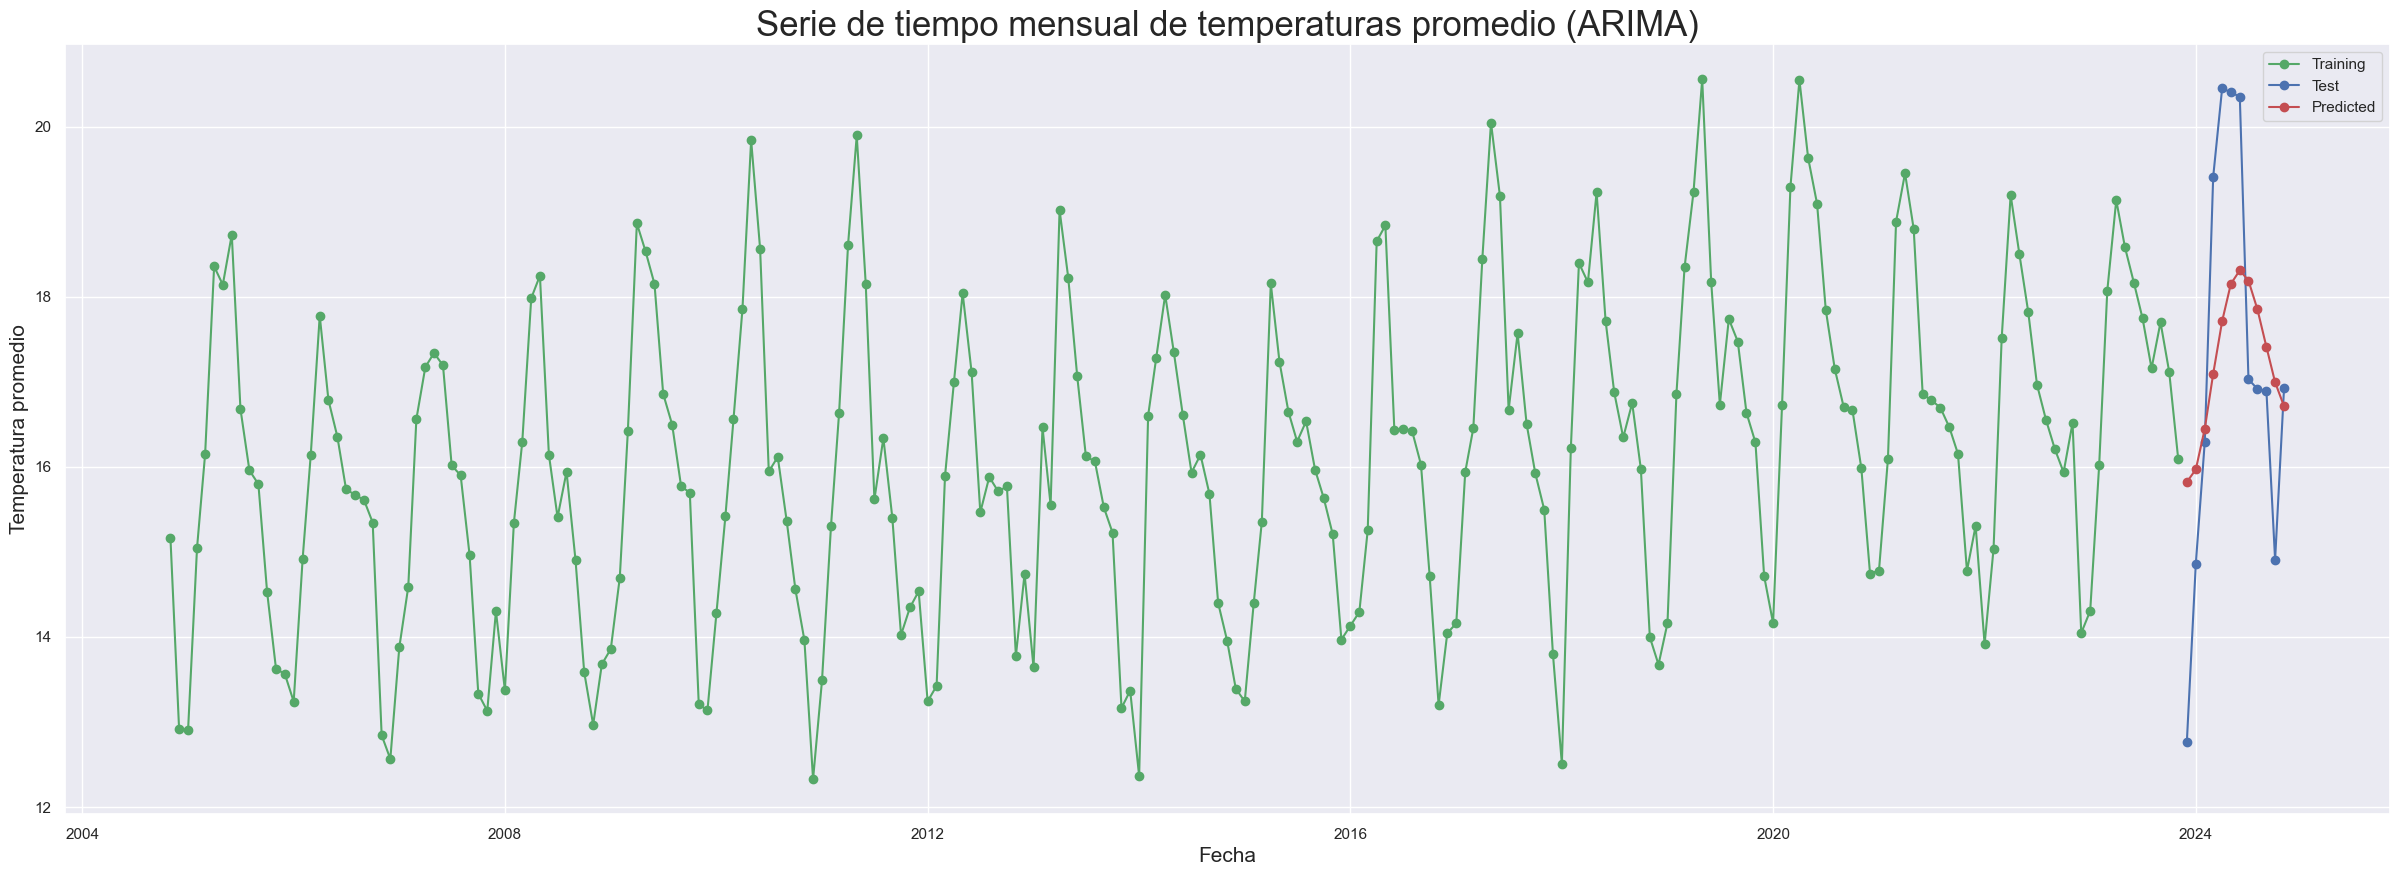

In [27]:

plt.figure(figsize=(30,10))
plt.plot(train,"go-",label="Training")
plt.plot(test,"bo-",label="Test")
plt.plot(prediction_ne,"ro-",label="Predicted")

plt.title("Serie de tiempo mensual de temperaturas promedio (ARIMA)",fontsize=25)
plt.xlabel("Fecha",fontsize=15)
plt.ylabel("Temperatura promedio",fontsize=15)

plt.legend(loc = 'best')
plt.show()



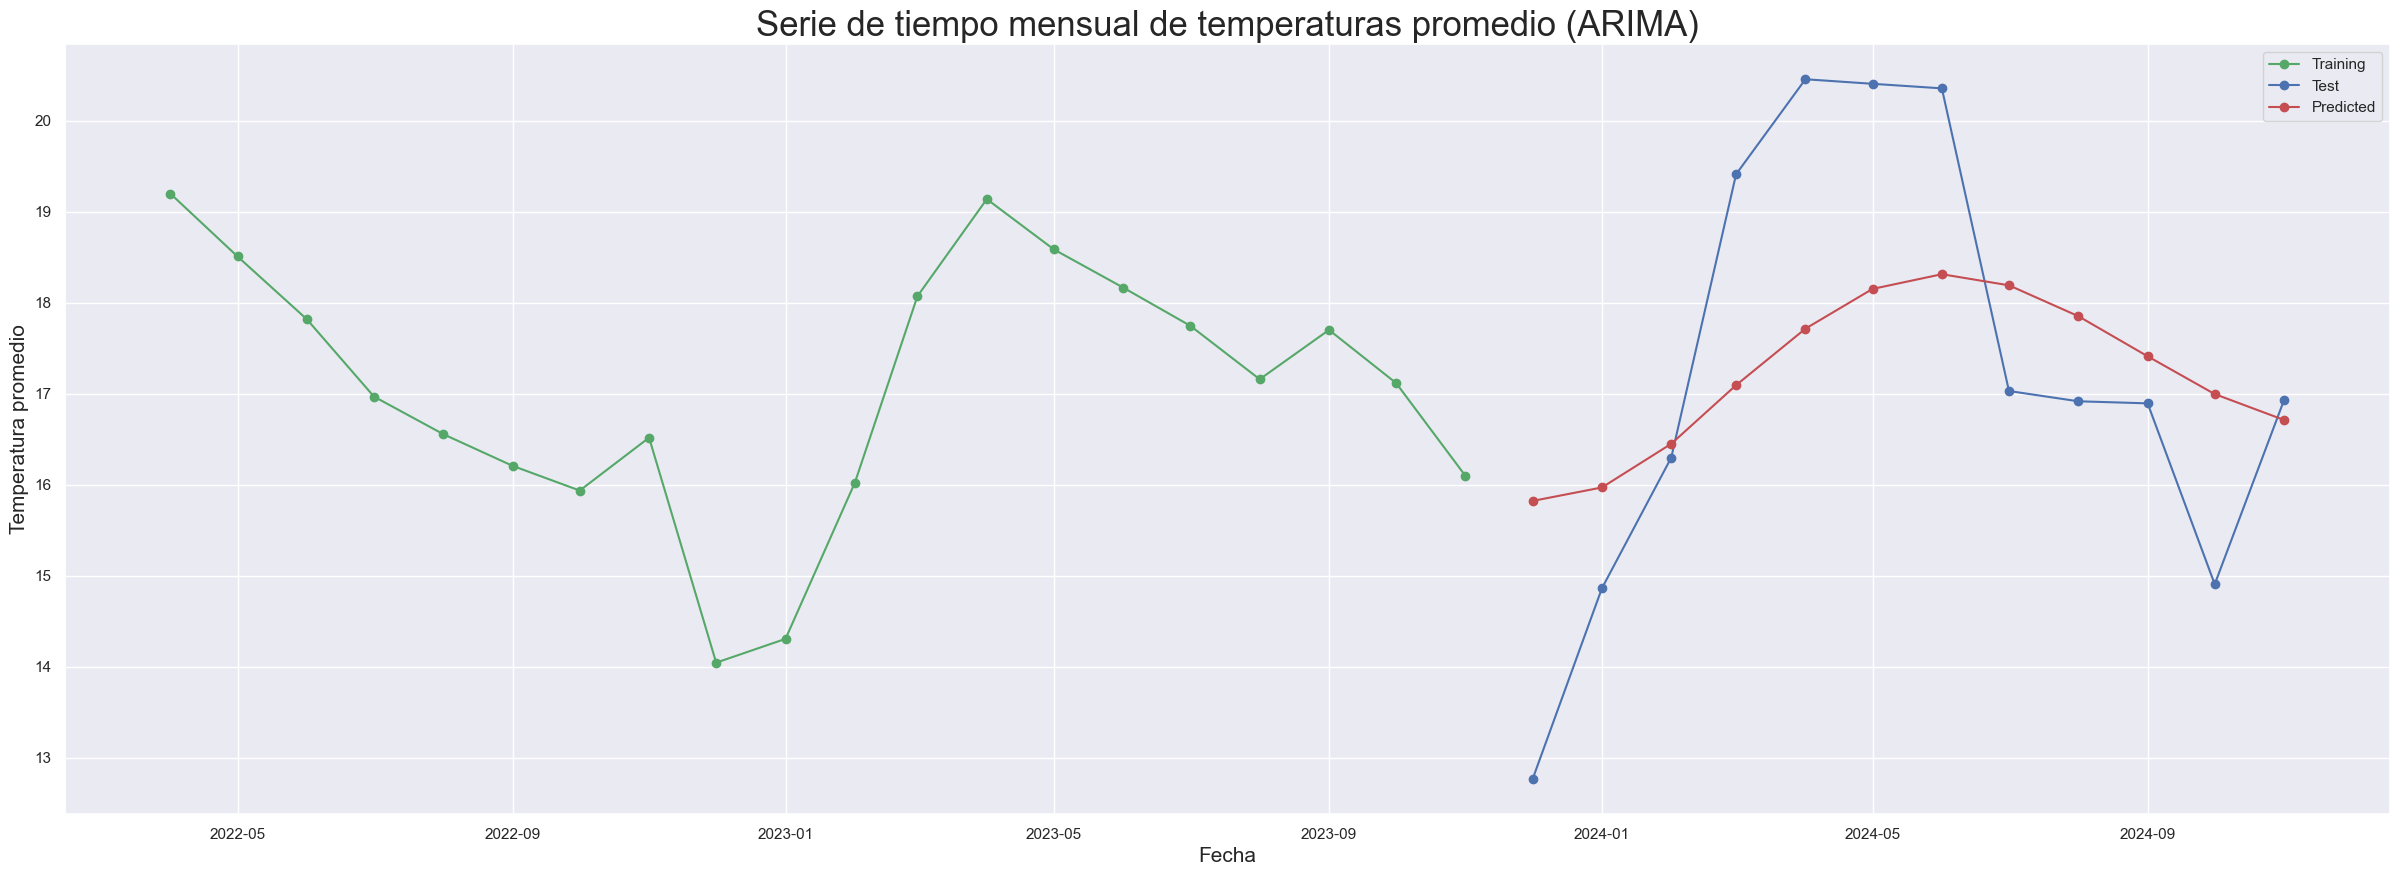

In [28]:
plt.figure(figsize=(30,10))
plt.plot(train[-20:],"go-",label="Training")
plt.plot(test[-20:],"bo-",label="Test")
plt.plot(prediction_ne,"ro-",label="Predicted")

plt.title("Serie de tiempo mensual de temperaturas promedio (ARIMA)",fontsize=25)
plt.xlabel("Fecha",fontsize=15)
plt.ylabel("Temperatura promedio",fontsize=15)

plt.legend(loc = 'best')
plt.show()



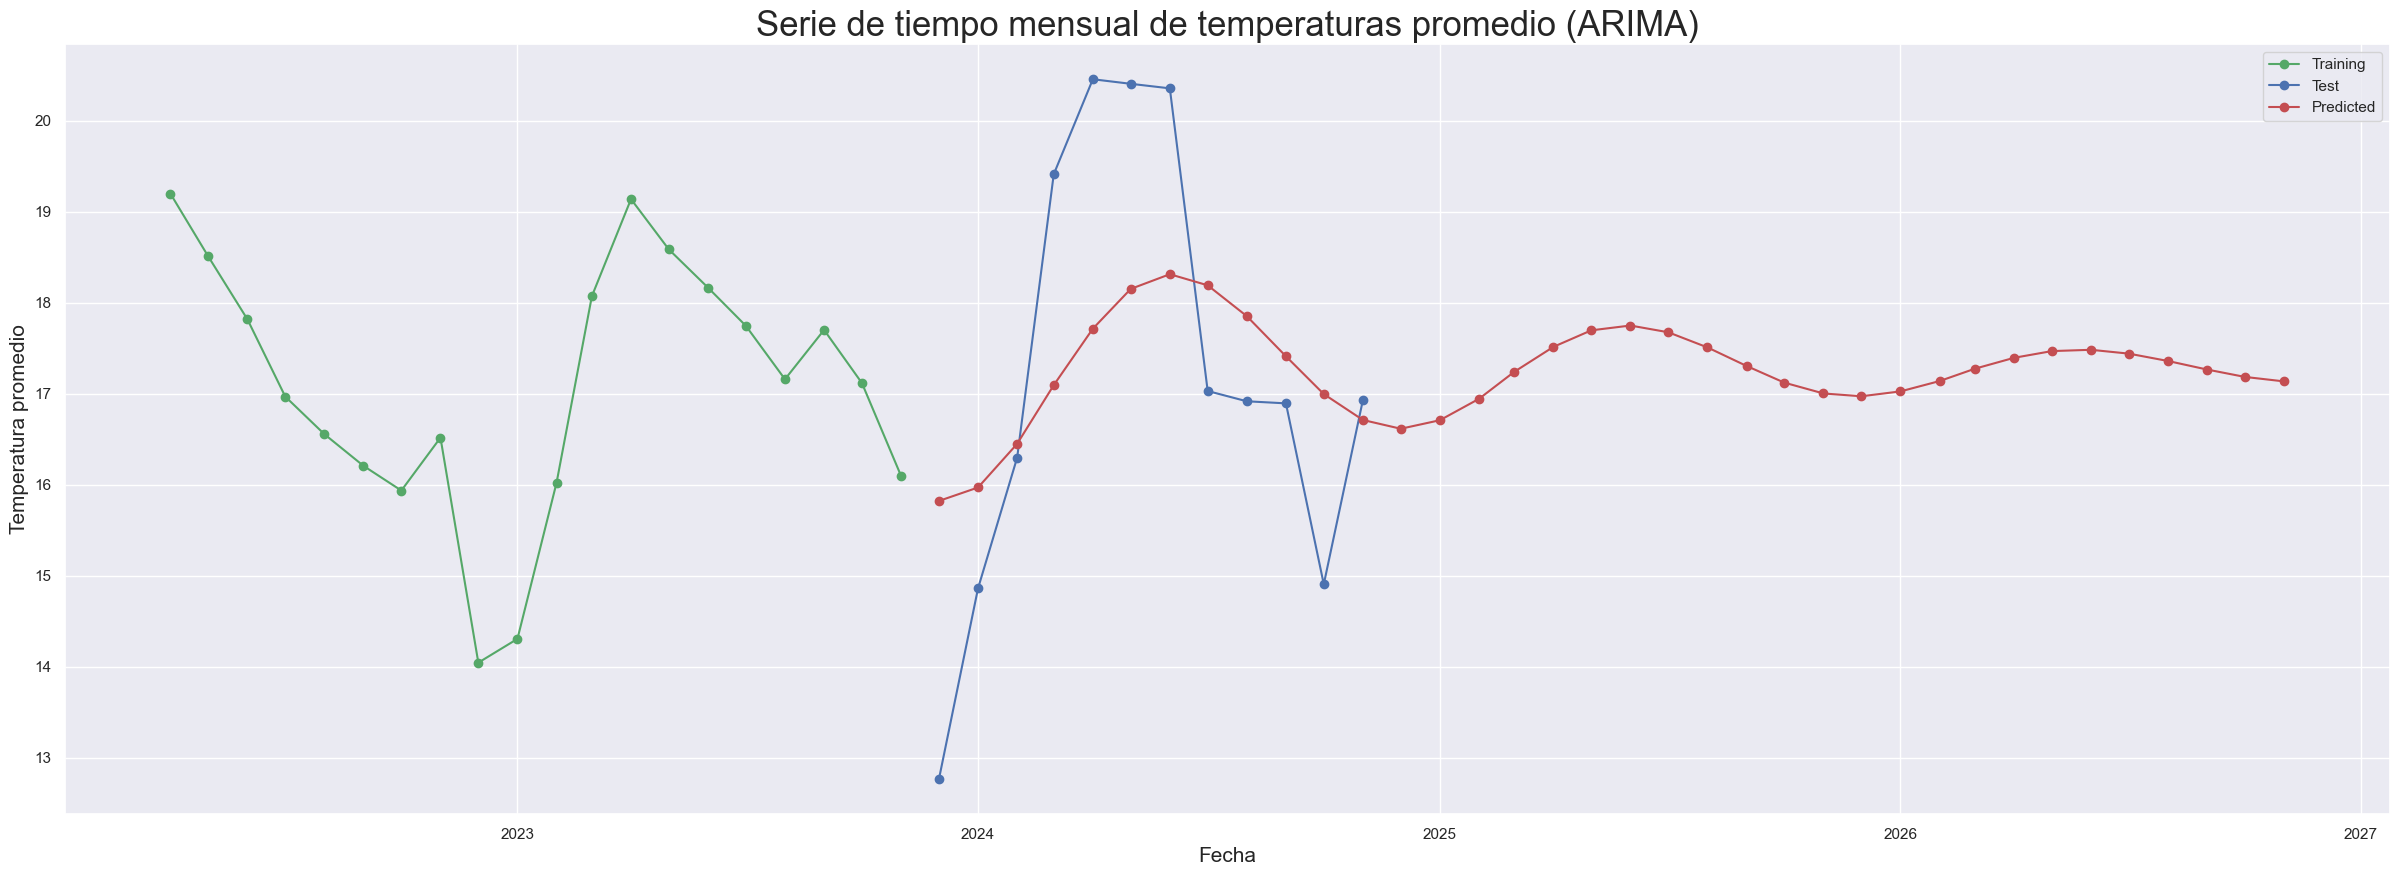

In [29]:
prediction_ne_2 = pd.DataFrame(arima_model_ne.predict(n_periods = 36))
prediction_ne_2.columns = ['predicted_yt']


plt.figure(figsize=(30,10))
plt.plot(train[-20:],"go-",label="Training")
plt.plot(test[-20:],"bo-",label="Test")
plt.plot(prediction_ne_2,"ro-",label="Predicted")

plt.title("Serie de tiempo mensual de temperaturas promedio (ARIMA)",fontsize=25)
plt.xlabel("Fecha",fontsize=15)
plt.ylabel("Temperatura promedio",fontsize=15)

plt.legend(loc = 'best')
plt.show()


In [30]:
### Metricas de error

y_test_ne = test.values  # Valores reales
y_pred_ne = prediction_ne.values  # Valores predichos

# 1. MAE
mae = mean_absolute_error(y_test_ne, y_pred_ne)
print(f"MAE: {mae}")

# 2. MSE
mse = mean_squared_error(y_test_ne, y_pred_ne)
print(f"MSE: {mse}")


# 3. RMSE
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

# 4. MAPE
mape = np.mean(np.abs((y_test_ne - y_pred_ne) / y_test_ne)) * 100
print(f"MAPE: {mape}%")

# 5. R²
r2 = r2_score(y_test_ne, y_pred_ne)
print(f"R²: {r2}")

MAE: 1.5490942961257035
MSE: 3.3011090341602585
RMSE: 1.8168954384224367
MAPE: 9.12126013103981%
R²: 0.4097477414060282


## Seleccion autoarima  : Modelo con estacionalidad SARIMA

### Hacemos la selección

In [31]:
arima_model =  auto_arima(train,start_p=0, d=0, start_q=0, 
                          max_p=4, max_d=4, max_q=4, start_P=0, 
                          D=0, start_Q=0, max_P=4, max_D=4,
                          max_Q=4, m=12, seasonal=True, 
                          error_action='ignore',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )
AutoARIMA()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=928.996, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=609.518, Time=0.39 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=704.405, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1927.239, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=746.459, Time=0.09 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=1.68 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=560.925, Time=0.91 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=679.870, Time=0.41 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=569.814, Time=2.92 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=564.567, Time=3.42 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=654.461, Time=1.53 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=3.63 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=603.876, Time=1.08 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=573.621, Time=1.95 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : A

AutoARIMA()

### Mejor modelo : SARIMA(1,0,0)(1,0,1)[12]

In [32]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  229
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -275.463
Date:                              Wed, 20 Nov 2024   AIC                            560.925
Time:                                      15:39:45   BIC                            578.094
Sample:                                  11-01-2004   HQIC                           567.852
                                       - 11-01-2023                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2925      0.149      1.966      0.049       0.001       0.584
ar.L1          0.4265      0.058      7.311      0.000       0.312       0.541
ar.S.L12       0.9683      0.016     59.044      0.000       0.936       1.000
ma.S.L12      -0.6482      0.067     -9.732      0.000      -0.779      -0.518
sigma2         0.6059      0.064      9.517      0.000       0.481       0.731
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 0.63
Prob(Q):                              0.80   Prob(JB):                         0.73
Heteroskedasticity (H):               1.05   Skew:                             0.08
Prob(H) (two-sided):                  0.83   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:

prediction = pd.DataFrame(arima_model.predict(n_periods = 12))
prediction.columns = ['predicted_yt']
prediction

,predicted_yt
2023-12-01,14.784105
2024-01-01,14.402384
2024-02-01,15.932940
2024-03-01,17.894936
2024-04-01,18.964421
2024-05-01,18.617611
2024-06-01,17.758762
2024-07-01,17.131658
2024-08-01,16.850109
2024-09-01,16.833998


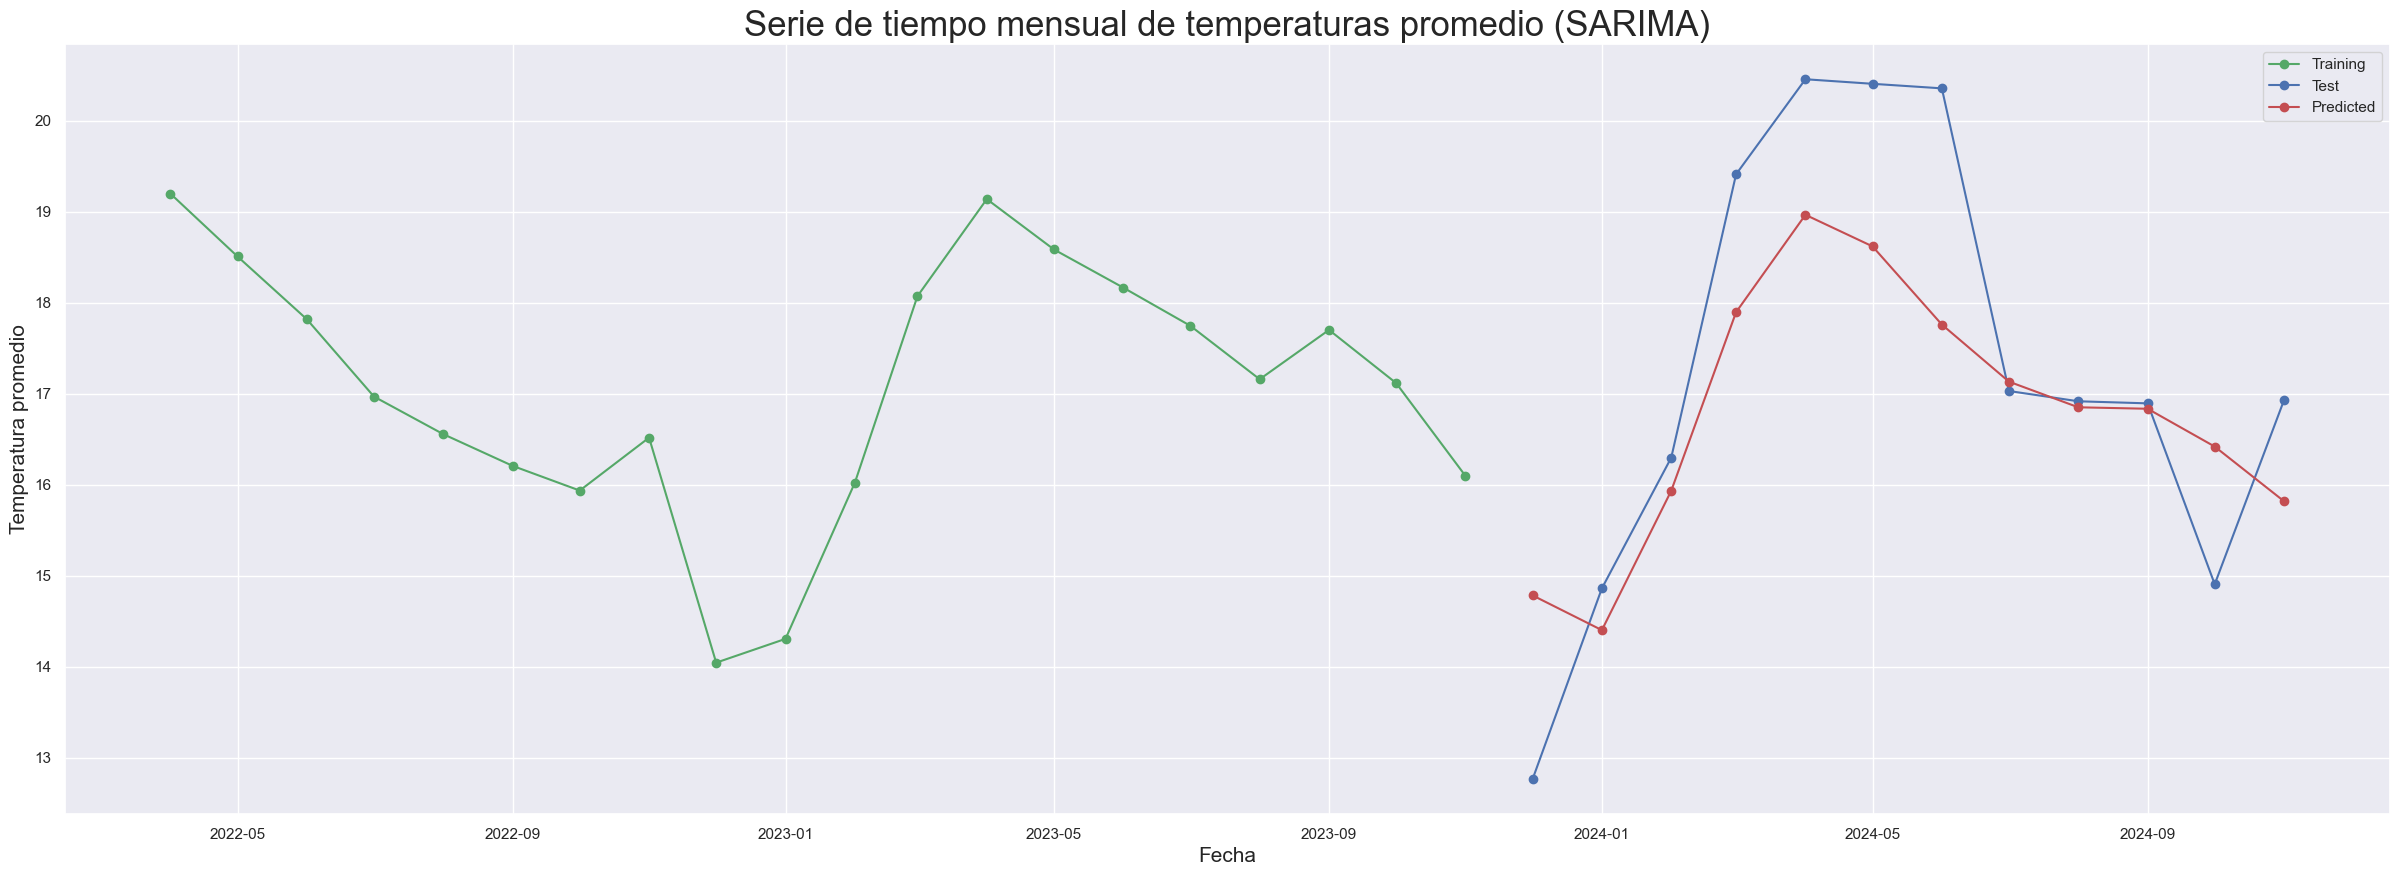

In [34]:
plt.figure(figsize=(30,10))
plt.plot(train[-20:],"go-",label="Training")
plt.plot(test[-20:],"bo-",label="Test")
plt.plot(prediction,"ro-",label="Predicted")

plt.title("Serie de tiempo mensual de temperaturas promedio (SARIMA)",fontsize=25)
plt.xlabel("Fecha",fontsize=15)
plt.ylabel("Temperatura promedio",fontsize=15)

plt.legend(loc = 'best')
plt.show()


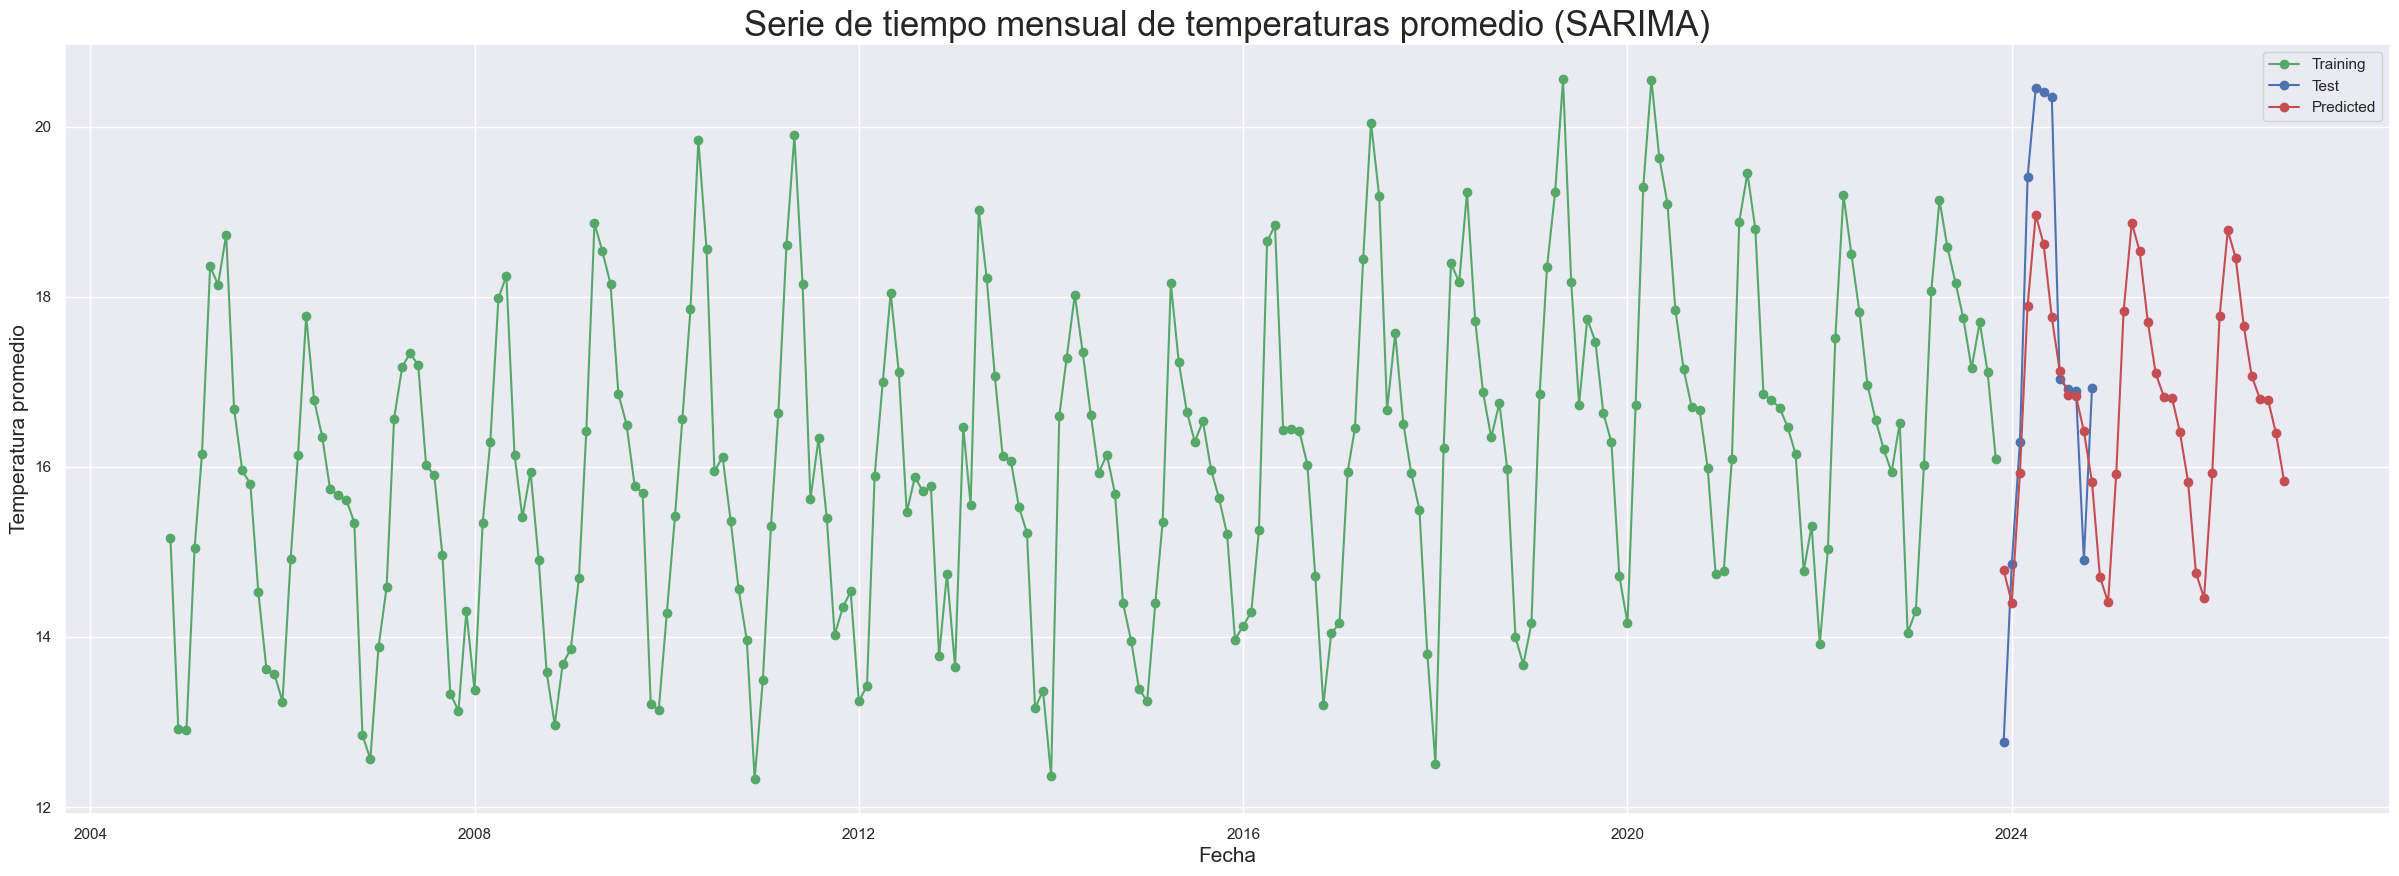

In [35]:
prediction_2 = pd.DataFrame(arima_model.predict(n_periods = 36))
prediction_2.columns = ['predicted_yt']


plt.figure(figsize=(30,10))
plt.plot(train,"go-",label="Training")
plt.plot(test,"bo-",label="Test")
plt.plot(prediction_2,"ro-",label="Predicted")

plt.title("Serie de tiempo mensual de temperaturas promedio (SARIMA)",fontsize=25)
plt.xlabel("Fecha",fontsize=15)
plt.ylabel("Temperatura promedio",fontsize=15)

plt.legend(loc = 'best')
plt.show()


In [36]:
### Metricas de error estacional

y_test = test.values  # Valores reales
y_pred = prediction.values  # Valores predichos

# 1. MAE
mae_e = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae_e}")

# 2. MSE
mse_e = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse_e}")

# 3. RMSE
rmse_e = np.sqrt(mse)
print(f"RMSE: {rmse_e}")

# 4. MAPE
mape_e = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"MAPE: {mape_e}%")

# 5. R²
r2_e = r2_score(y_test, y_pred)
print(f"R²: {r2_e}")

MAE: 1.089870702819453
MSE: 1.866300020413429
RMSE: 1.8168954384224367
MAPE: 6.315219265387261%
R²: 0.6662976621300163


In [37]:
### Metricas de error no estacional

# 1. MAE

print(f"MAE: {mae}")

# 2. MSE

print(f"MSE: {mse}")

# 3. RMSE

print(f"RMSE: {rmse}")

# 4. MAPE

print(f"MAPE: {mape}%")

# 5. R²

print(f"R²: {r2}")

MAE: 1.5490942961257035
MSE: 3.3011090341602585
RMSE: 1.8168954384224367
MAPE: 9.12126013103981%
R²: 0.4097477414060282


### Anaisis del modelo

In [38]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [40]:
modelo = SARIMAX(train, order=(1,0,0),seasonal_order=(1,0,1,12),trend='c')
ajuste = modelo.fit()

In [41]:
# Resumen del ajuste
print(ajuste.summary())

                                      SARIMAX Results                                       
Dep. Variable:                  temperature_2m_mean   No. Observations:                  229
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -275.463
Date:                              Wed, 20 Nov 2024   AIC                            560.925
Time:                                      15:41:45   BIC                            578.094
Sample:                                  11-01-2004   HQIC                           567.852
                                       - 11-01-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2925      0.149      1.966      0.049       0.001       0.584
ar.L1          0.42

## B-J paso 3

### Predicciones

In [42]:
# Obtener las predicciones y los intervalos de confianza
forecast = ajuste.get_forecast(steps=len(test))  # Predicciones para los datos de prueba

# Obtener el intervalo de confianza del 95%
conf_int = forecast.conf_int(alpha=0.05)

In [43]:
conf_int

,lower temperature_2m_mean,upper temperature_2m_mean
2023-12-01,13.258425,16.309786
2024-01-01,12.743719,16.061048
2024-02-01,14.251212,17.614668
2024-03-01,16.209046,19.580825
2024-04-01,17.277775,20.651066
2024-05-01,16.930828,20.304394
2024-06-01,16.071954,19.445570
2024-07-01,15.444845,18.818470
2024-08-01,15.163296,18.536923
2024-09-01,15.147185,18.520812


In [ ]:
prediction

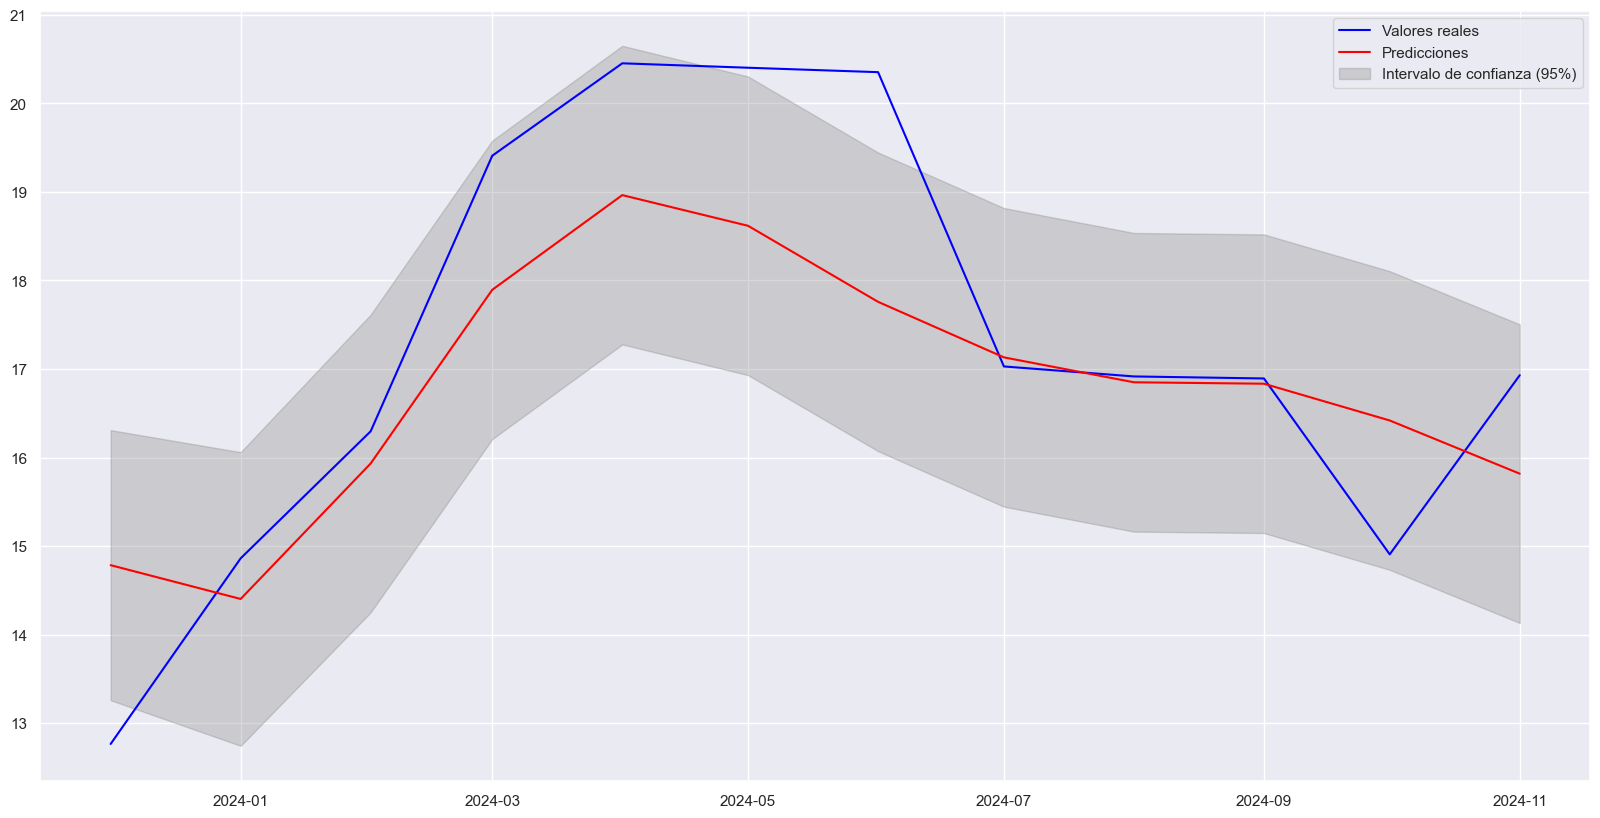

In [44]:
# Graficar las predicciones y el intervalo de confianza
plt.figure(figsize=(20,10))
plt.plot(test.index, test, label='Valores reales', color='blue')
plt.plot(test.index, forecast.predicted_mean, label='Predicciones', color='red')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3, label='Intervalo de confianza (95%)')
plt.legend()
plt.show()

## Análisis de residuos

## B-J paso 4

In [45]:
# Obtener los residuos del ajuste
residuos = ajuste.resid[1:]
print(residuos)

time
2004-12-01   -2.781157
2005-01-01   -1.826255
2005-02-01    0.320191
2005-03-01    0.511090
2005-04-01    2.242475
                ...   
2023-07-01    0.641698
2023-08-01    0.053584
2023-09-01    1.076801
2023-10-01    0.489538
2023-11-01   -0.007698
Freq: MS, Length: 228, dtype: float64


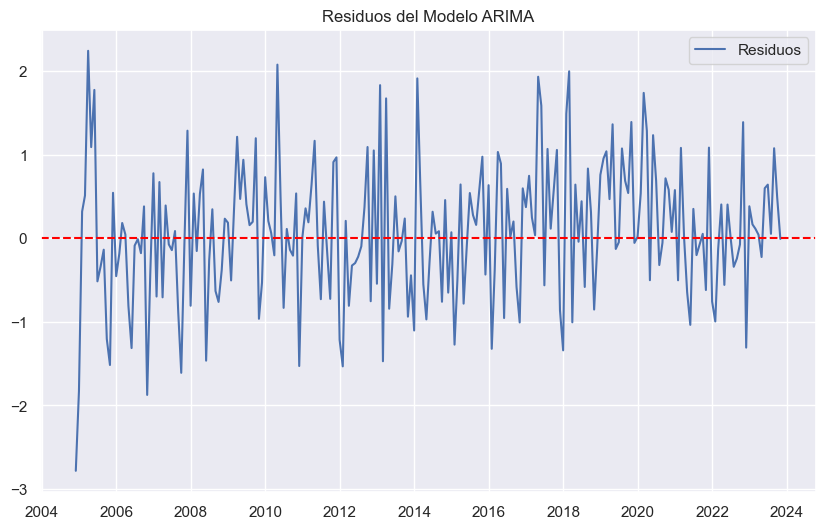

In [46]:
# Gráfico de los residuos
plt.figure(figsize=(10, 6))
plt.plot(residuos, label="Residuos")
plt.axhline(0, color='red', linestyle='--')
plt.legend()
plt.title("Residuos del Modelo ARIMA")
plt.show()

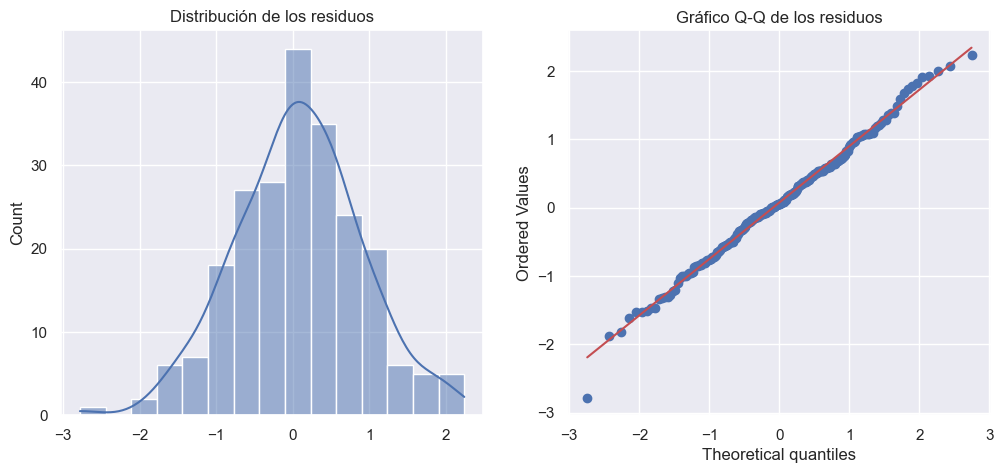

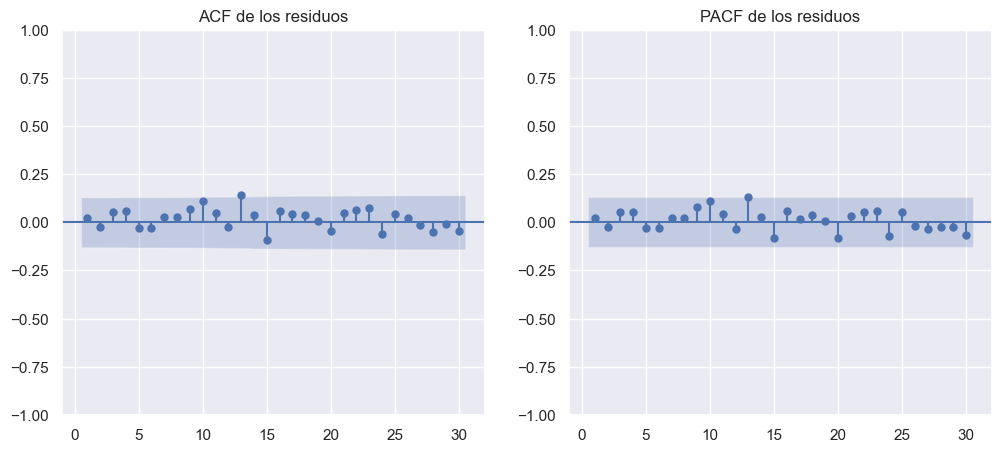

In [47]:
# Histograma y gráfico Q-Q para verificar normalidad
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(residuos, kde=True)
plt.title("Distribución de los residuos")

plt.subplot(1, 2, 2)
stats.probplot(residuos, dist="norm", plot=plt)
plt.title("Gráfico Q-Q de los residuos")
plt.show()

# Gráficos de autocorrelación (ACF y PACF)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(residuos, ax=plt.gca(), lags=30,zero=False)
plt.title("ACF de los residuos")

plt.subplot(1, 2, 2)
plot_pacf(residuos, ax=plt.gca(), lags=30,zero=False)
plt.title("PACF de los residuos")
plt.show()

In [48]:
# Calcular la media y desviación estándar de los residuos
media_residuos = residuos.mean()
desviacion_residuos = residuos.std()

# Estandarizar los residuos
residuos_estandarizados = (residuos - media_residuos) / desviacion_residuos

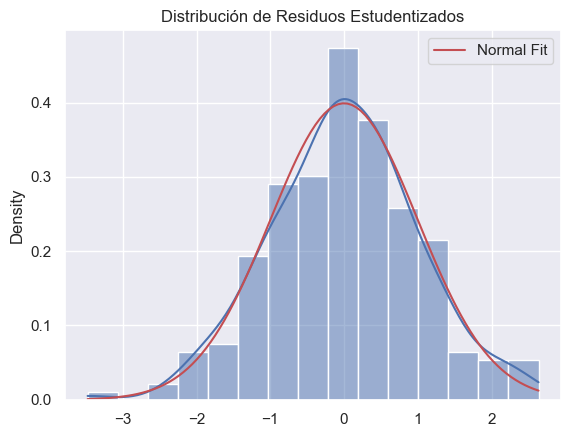

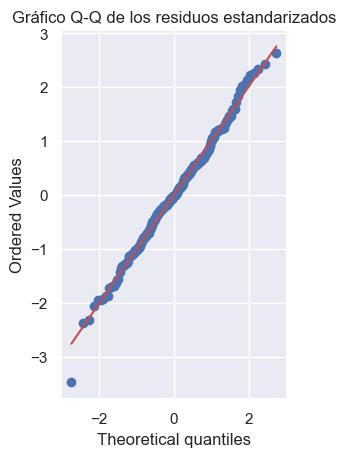

In [49]:
# Histograma de los residuos normalizados

sns.histplot(residuos_estandarizados, kde=True, stat="density")
xfit = np.linspace(min(residuos_estandarizados), max(residuos_estandarizados), 100)
yfit = norm.pdf(xfit)
plt.plot(xfit, yfit, 'r-', label='Normal Fit')
plt.title("Distribución de Residuos Estudentizados")
plt.legend()
plt.show()

# Gráfico Q-Q para comparar con una distribución normal
plt.subplot(1, 2, 2)
stats.probplot(residuos_estandarizados, dist="norm", plot=plt)
plt.title("Gráfico Q-Q de los residuos estandarizados")
plt.show()

### Pruebas estadisticas de significancia en el error

In [50]:
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import het_breuschpagan

## Normalidad

In [ ]:
?jarque_bera

In [51]:
### JARQUE BERA

# Normalidad en los residuos
jb_test = jarque_bera(residuos)
print("Jarque-Bera Test:", jb_test)

## estadistica //// p value   /// Asime   // kurto
## HO : normalidad
#  HA : no normalidad

#  Hay normalidad

Jarque-Bera Test: (0.7411149817144429, 0.6903493598820643, -0.056393975199406976, 3.2555210002782493)


## Independencia de error


In [52]:
## (Durbin-Watson)

# Prueba de independencia de los errores 
dw_test = sm.stats.durbin_watson(residuos)
print("Durbin-Watson Test:", dw_test)

#No autocorrelacion

Durbin-Watson Test: 1.8867999992914433


In [53]:
#  Ljung-Box

from statsmodels.stats.diagnostic import acorr_ljungbox

# Usar la función Ljung-Box para comprobar la autocorrelación
ljung_box_test = acorr_ljungbox(residuos, lags=1)  # Lags=1 es para una lag de primer orden

# los residuos son independientes

In [54]:
ljung_box_test

,lb_stat,lb_pvalue
1,0.110391,0.739699


## Prueba de heterocedasticidad 

In [55]:
#  (Breusch-Pagan)
X_sm = sm.add_constant(train[1:].values)


bp_test = het_breuschpagan(residuos, X_sm )

# Extraer los resultados
lm_stat = bp_test[0]        # Estadístico de LM
lm_pvalue = bp_test[1]      # Valor p asociado al estadístico de LM
f_stat = bp_test[2]         # Estadístico F
f_pvalue = bp_test[3]       # Valor p asociado al estadístico F

print("Estadístico LM:", lm_stat)
print("Valor p de LM:", lm_pvalue)
print("Estadístico F:", f_stat)
print("Valor p de F:", f_pvalue)


Estadístico LM: 0.29562990710832926
Valor p de LM: 0.586635136583388
Estadístico F: 0.2934171135109302
Valor p de F: 0.5885726540157813


In [ ]:
## Hay homosedasticidad